# HW1

## a)

In [1]:
import numpy as np
from scipy.special import factorial

In [2]:
def model(t,
          lamb=1,
          delta=1):
    return lamb / delta * (1 - np.exp(- delta * t))

In [3]:
def prior(mu=1,
          sigma2=1,
          theta=1,
          ):
    return np.exp(- (theta - mu) ** 2/(2 * sigma2)) / ((2 * np.pi * sigma2) ** 0.5)

In [4]:
def likelihood(x_i, y):
    n = len(y)
    L_i = np.zeros(n)
    for i in range(n):
        L_i[i] = ((x_i ** y[i]) * np.exp(- x_i))/factorial(y[i])
    return L_i.prod()

In [5]:
lamb, delta = np.loadtxt('Input.txt')

In [6]:
y = [10, 10, 11, 8, 9, 7, 8, 9, 9, 10]
t = 100

In [7]:
np.array(y).prod()

np.int64(3592512000)

In [8]:
prior_lamb = prior(mu=15,
                   sigma2=5, 
                   theta=lamb)

prior_delta = prior(mu=1,
                   sigma2=10, 
                   theta=delta)

x_i = model(100, lamb=lamb, delta=delta)

L = likelihood(x_i, y)

In [9]:
neg_log_prior = - np.log(prior_lamb * prior_delta)
neg_log_likelihood = - np.log(L)
neg_log_post = - np.log(prior_lamb * prior_delta * L)

In [10]:
results = [
    neg_log_likelihood,
    neg_log_prior,
    neg_log_post
]

In [11]:
np.savetxt('Exc9Task1a.txt', results, fmt='%1.2f')

## b)

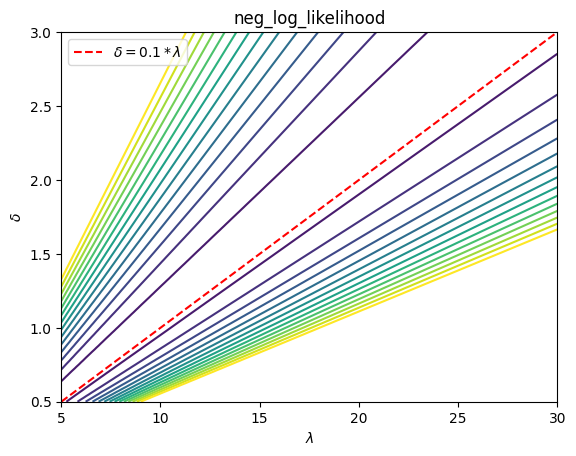

In [12]:
import numpy as np
import matplotlib.pyplot as plt

lamb_ = np.linspace(5, 30, 100)
delta_ = np.linspace(0.5, 3, 100)

lamb_mesh, delta_mesh = np.meshgrid(lamb_, delta_)
levels = np.arange(20, 50, 2)

x = np.zeros(lamb_mesh.shape)
L_val = np.zeros(lamb_mesh.shape)

for i in range(lamb_mesh.shape[0]):
    for j in range(lamb_mesh.shape[1]):
        x[i, j] = model(100, lamb=lamb_mesh[i, j], delta=delta_mesh[i, j])
        L_val[i, j] = likelihood(x[i, j].item(), y)

neg_log_likelihood_val = - np.log(L_val)

plt.contour(lamb_mesh, delta_mesh, neg_log_likelihood_val, levels)
plt.plot(lamb_, 0.1 * lamb_, '--', color='red', label=r'$\delta = 0.1 * \lambda$')
plt.ylabel(r'$\delta$')
plt.xlabel(r'$\lambda$')
plt.title('neg_log_likelihood')
plt.legend()

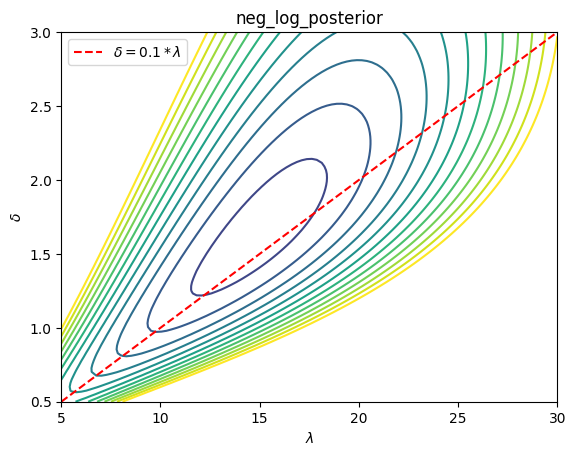

In [13]:
import numpy as np
import matplotlib.pyplot as plt

lamb_ = np.linspace(5, 30, 100)
delta_ = np.linspace(0.5, 3, 100)

lamb_mesh, delta_mesh = np.meshgrid(lamb_, delta_)
levels = np.arange(20, 50, 2)

x = np.zeros(lamb_mesh.shape)
post_val = np.zeros(lamb_mesh.shape)

for i in range(lamb_mesh.shape[0]):
    for j in range(lamb_mesh.shape[1]):
        x[i, j] = model(100, lamb=lamb_mesh[i, j], delta=delta_mesh[i, j])

        prior_lamb_ij = prior(mu=15,
                   sigma2=5, 
                   theta=lamb_mesh[i, j])

        prior_delta_ij = prior(mu=1,
                           sigma2=10, 
                           theta=delta_mesh[i, j])
        
        post_val[i, j] = likelihood(x[i, j].item(), y) * prior_lamb_ij * prior_delta_ij

neg_log_post_val = - np.log(post_val)

plt.contour(lamb_mesh, delta_mesh, neg_log_post_val, levels)
plt.plot(lamb_, 0.1 * lamb_, '--', color='red', label=r'$\delta = 0.1 * \lambda$')
plt.ylabel(r'$\delta$')
plt.xlabel(r'$\lambda$')
plt.title('neg_log_posterior')
plt.legend()

## Discussion 
## TODO

# HW2

## a)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In = np.loadtxt('Input2.txt')
np.random.seed(seed=int(In))

In [15]:
def compute_post(y, t, par):
    lamb, delta = par
    
    prior_lamb = prior(mu=15,
                   sigma2=5, 
                   theta=lamb)

    prior_delta = prior(mu=1,
                       sigma2=10, 
                       theta=delta)
    
    x_i = model(t, lamb=lamb, delta=delta)
    
    L = likelihood(x_i, y)

    return (prior_lamb * prior_delta * L)

In [16]:
def sample_par(par, sigma=3):
    lamb = np.random.normal(par[0], sigma)
    delta = np.random.normal(par[1], sigma)
    
    return [lamb, delta]

In [17]:
def save(par, name):
    np.savetxt(name, par, delimiter=',', fmt='%1.2f')

In [18]:
def MCMC(init, 
         n=10, 
         compute_post=None,
         sample_par=None,
         **kwargs):
    
    def criteria(p_cur, 
                 p_next):
        
        return min(1, p_next/p_cur)
    
    par_cur = init
    kwargs['par'] = par_cur
    post_cur = compute_post(**{**kwargs, **{'par': par_cur}})
    pars = []

    for i in range(n):
        par_next = sample_par(par_cur)
        if (par_next[0] < 0 or par_next[1] < 0):
            post_next = 0
        else:
            post_next = compute_post(**{**kwargs, **{'par': par_next}})
    
        r = np.random.uniform(0, 1)
    
        if r < criteria(post_cur, post_next):
            par_cur = par_next
            post_cur = post_next
        pars.append(par_cur)
        
    
    return pars

In [19]:
init = [30, 3]

pars = MCMC(init, 
         compute_post=compute_post, 
         sample_par=sample_par,
         y=y,
         t=100)

In [20]:
save(pars, 'Exc9Task2_.txt')

## b)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [22]:
def plot_hists(pars):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(pars[:, 0], density=True)
    axes[0].set_title(r'$\lambda$')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')
    
    axes[1].hist(pars[:, 1], density=True)
    axes[1].set_title(r'$\delta$')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')
    
    plt.show()

In [23]:
def plot_joint(pars):
    lamb_ = np.linspace(5, 30, 100)
    delta_ = np.linspace(0.5, 3, 100)
    
    lamb_mesh, delta_mesh = np.meshgrid(lamb_, delta_)
    positions = np.vstack([lamb_mesh.ravel(), delta_mesh.ravel()])
    
    kernel = stats.gaussian_kde(pars.T)
    
    f = np.reshape(kernel(positions).T, lamb_mesh.shape)
    plt.pcolormesh(lamb_mesh, delta_mesh, f)

    plt.contour(lamb_mesh, delta_mesh, f)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\delta$')
    plt.title('kernel density plot')
    
    plt.show()

### 1. $\theta = (30, 3)$

In [24]:
In = np.loadtxt('Input2.txt')
np.random.seed(seed=int(In))

init = [30, 3]

pars = MCMC(init, 
         compute_post=compute_post, 
         sample_par=sample_par,
         y=y,
         t=100,
         n=20000)

pars = np.array(pars)
pars_disregarded = pars[int(pars.shape[0] * 0.9):, :]

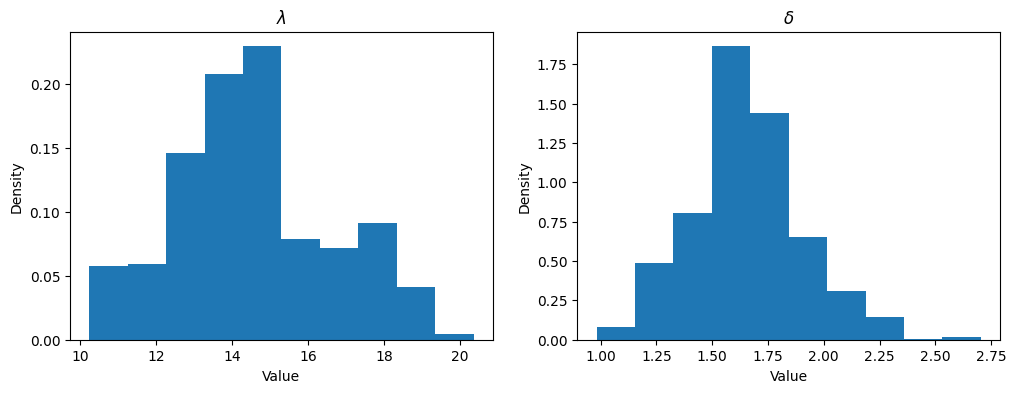

In [25]:
plot_hists(pars_disregarded)

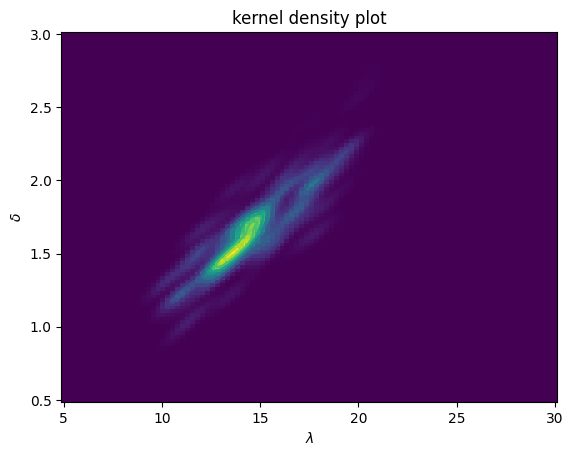

In [26]:
plot_joint(pars_disregarded)

### 2. $\theta$ randomized

In [27]:
np.random.seed(seed=int(In))

init = [np.random.uniform(0, 1) * 25 + 5, 
        np.random.uniform(0, 1) * 2.5 + 0.5]
print('Initial parameters after randomization: lambda=%.3f  and theta=%.3f' % (init[0], init[1]))
pars = MCMC(init, 
         compute_post=compute_post, 
         sample_par=sample_par,
         y=y,
         t=100,
         n=20000)

pars = np.array(pars)
pars_disregarded = pars[int(pars.shape[0] * 0.9):, :]

Initial parameters after randomization: lambda=18.770  and theta=2.270


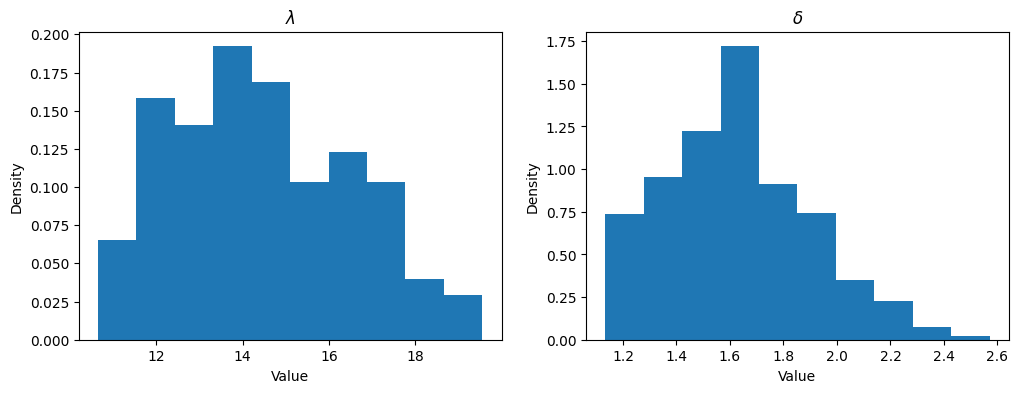

In [28]:
plot_hists(pars_disregarded)

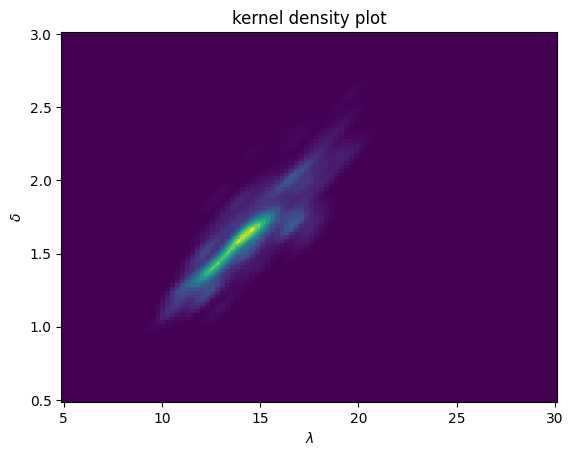

In [29]:
plot_joint(pars_disregarded)

## Discussion
## TODO